# Simulation and Performance Evaluation - Homework 4

### University of Trento - A.Y. 2019 / 2020

Lotito Quintino Francesco - 215032

Zanella Davide - 211463

---

**Important:** we delivered two files, a .ipynb file (jupyter notebook) and a .html file (export of the notebook), if the .ipynb file is run we expect the datasets to be in the same directory of this notebook in order to be read as input.

## Exercise 1

Let's start defining the different types of event that we will use.

In [1]:
from enum import Enum

class EventTypes(Enum):
    start_simulation = 0,
    end_simulation = 1,
    packet_arrival = 2,
    packet_departure = 3,
    debug = 4

The following is the class representing an event. Its properties are the occurrence time, the type of the event and the pointer to the next occurring event.

In [2]:
class Event:
    def __init__(self, occ_time, event_type:EventTypes):
        self.occurrence_time = occ_time
        self.event_type = event_type
        self.next_event = None

Now, we need a class representing the Queue. It has a property pointing to the first event of the queue.
It's defined a method to insert an event in the queue linking it between the two events occurring immediatly before and after the event we are inserting.
There is a useful method to print the whole queue following the links between the events.
The last method of the Queue class extracts the first element of the queue removing it from the queue.

In [3]:
class Queue:
    def __init__(self):
        self.first_event = None


    def insert_event(self, event:Event):
        if event.occurrence_time < self.first_event.occurrence_time:
            event.next_event = self.first_event
            self.first_event = event
        else:
            curr_event = self.first_event
            while curr_event.next_event is not None and \
                    event.occurrence_time > curr_event.next_event.occurrence_time:
                curr_event = curr_event.next_event

            event.next_event = curr_event.next_event
            curr_event.next_event = event


    def print(self):
        curr_event = self.first_event
        while curr_event is not None:
            print("->", curr_event.occurrence_time, curr_event.event_type)
            curr_event = curr_event.next_event


    def pop(self):
        if self.first_event is None:
            return None

        curr_event = self.first_event
        self.first_event = self.first_event.next_event

        return curr_event

To be certain that the previous code works properly let's give it a try creating the start and end of a simulation events,
adding them to the Queue and print its content.

In [4]:
queue = Queue()
curr_time = 0
max_time = 1000

start_event = Event(curr_time, EventTypes.start_simulation)
end_event = Event(max_time, EventTypes.end_simulation)

queue.first_event = start_event
queue.insert_event(end_event)

queue.print()

-> 0 EventTypes.start_simulation
-> 1000 EventTypes.end_simulation


We can even try adding some events not ordered and check that queue automatically put them in the correct order while inserting them.

In [5]:
events = [
    Event(100, EventTypes.packet_departure),
    Event(-50, EventTypes.packet_arrival),
    Event(842, EventTypes.packet_departure),
    Event(684, EventTypes.packet_arrival),
    Event(354, EventTypes.packet_arrival),
    Event(956, EventTypes.packet_departure),
    Event(715, EventTypes.debug),
    Event(20, EventTypes.packet_arrival),
    Event(953, EventTypes.packet_departure)
]

for e in events:
    queue.insert_event(e)

queue.print()

-> -50 EventTypes.packet_arrival
-> 0 EventTypes.start_simulation
-> 20 EventTypes.packet_arrival
-> 100 EventTypes.packet_departure
-> 354 EventTypes.packet_arrival
-> 684 EventTypes.packet_arrival
-> 715 EventTypes.debug
-> 842 EventTypes.packet_departure
-> 953 EventTypes.packet_departure
-> 956 EventTypes.packet_departure
-> 1000 EventTypes.end_simulation


Now, we need a class for the server. Every server should have a queue of the packets to be processed and a status, meaning if the server is busy (`1`) or free (`0`).

In [6]:
class Server:
    def __init__(self):
        self.server_status = 0  # 0 means available, 1 means busy
        self.queue = []

The following code is a skeleton of the workflow adopted to manage a queue of events.

In [7]:
while True:
    event = queue.pop()
    if event is None:
        continue
    if event.event_type == EventTypes.start_simulation:
        print("start simulation")
    elif event.event_type == EventTypes.packet_arrival:
        print("packet arrival")
    elif event.event_type == EventTypes.packet_departure:
        print("packet departure")
    elif event.event_type == EventTypes.debug:
        print("debug")
    elif event.event_type == EventTypes.end_simulation:
        print("end simulation")
        break

packet arrival
start simulation
packet arrival
packet departure
packet arrival
packet arrival
debug
packet departure
packet departure
packet departure
end simulation


Let's define two functions. The first one simply extract a number from an exponential distribution given the lambda parameter.
The second one simulates the arrival of some packets to our server using the first function to decide the inter-arrival time.

In [8]:
import random as rnd

def exponential_val(lambda_val):
    return rnd.expovariate(lambda_val)


def simulate(arr_val, max_time):
    curr_time = 0
    queue = Queue()

    arrival_time = exponential_val(arr_val)
    curr_time += arrival_time

    queue.first_event = Event(curr_time, EventTypes.start_simulation)

    while curr_time < max_time:
        arrival_time = exponential_val(arr_val)
        curr_time += arrival_time

        if curr_time >= max_time:
            e = Event(curr_time, EventTypes.end_simulation)
        else:
            e = Event(curr_time, EventTypes.packet_arrival)

        queue.insert_event(e)

    return queue

The following function is an evolution of the skeleton defined before, managing the arrival of a packet and scheduling its departure sampling from the exponential distribution.

In [9]:
def manage_packets(q, server, server_lambda):
    packet_time = []
    packet_status = []
    delay_in_queue = []
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            if server.server_status == 0:  # server free
                server.server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                q.insert_event(e)
            else:  # server busy
                server.queue.append(event)
        elif event.event_type == EventTypes.packet_departure:
            if len(server.queue) == 0:
                server.server_status = 0
            else:  # schedule next departure event
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                q.insert_event(e)

                delay_in_queue.append(e.occurrence_time - server.queue[0].occurrence_time)
                server.queue = server.queue[1:]  # remove first packet from the queue
        elif event.event_type == EventTypes.debug:
            print("debug")
        elif event.event_type == EventTypes.end_simulation:
            break

        if len(packet_time) and event.occurrence_time < packet_time[-1]:
            print(event.occurrence_time, event.event_type)
            print(packet_time[-1])

        packet_time.append(event.occurrence_time)
        num_packets = len(server.queue) + server.server_status
        packet_status.append(num_packets)

    return packet_time, packet_status, delay_in_queue

The following is a useful function that uses the functions defined previously.
It simulates the arrival and the departure of some packets and then plots the number of packets in the system comparing it with the theoretical average value.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_simulation(lmbda, mu, max_time):
    q = simulate(lmbda, max_time)
    s = Server()
    packet_time, packet_status, _ = manage_packets(q, s, mu)

    plt.plot(packet_time, packet_status)

    p = lmbda / mu
    theory_val = p/(1-p)
    theoretical = [theory_val] * len(packet_time)

    plt.plot(packet_time, theoretical)

    plt.xlabel('Time in seconds')
    plt.ylabel('Number of packets in the system')
    plt.legend(['simulated values', 'theoretical value'])
    plt.title('Number of packets in the system - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

As can be seen from the following plots, keeping constant the parameter for the exponential random variable of the serving time, the growth of the lambda for the inter-arrival time, the more the number of packets in the system.

When the lambda is too high with respect to the mu, the growth of the number of packets in the system is linear.
This means that the server takes too much time to manage a packet, but some new packets are generated in the meantime.

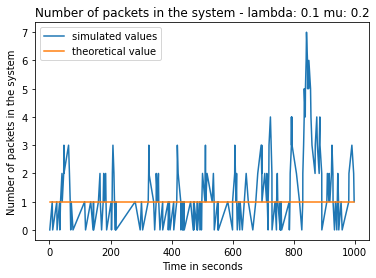

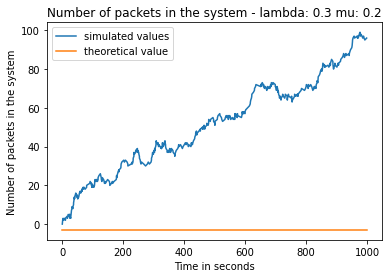

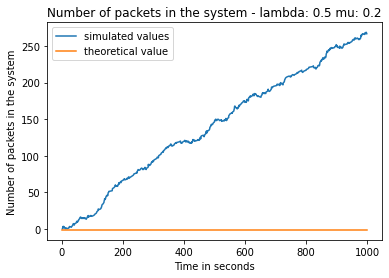

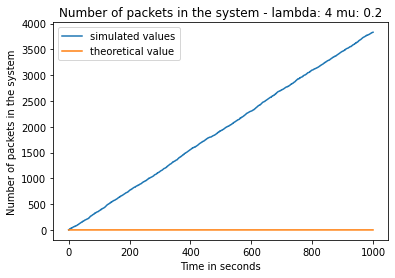

In [11]:
plot_simulation(0.1, 0.2, 1000)
plot_simulation(0.3, 0.2, 1000)
plot_simulation(0.5, 0.2, 1000)
plot_simulation(4, 0.2, 1000)

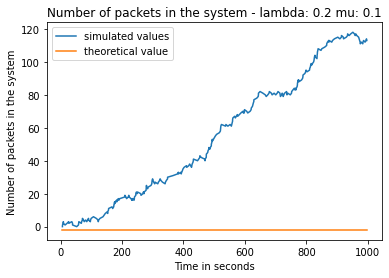

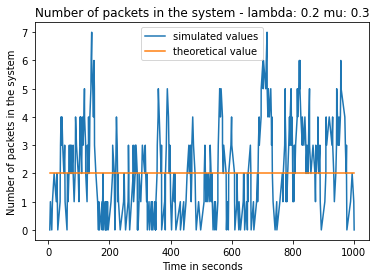

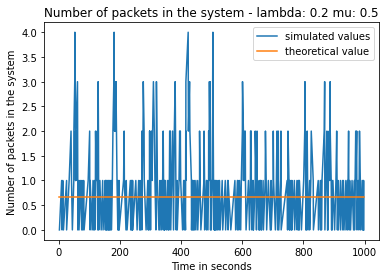

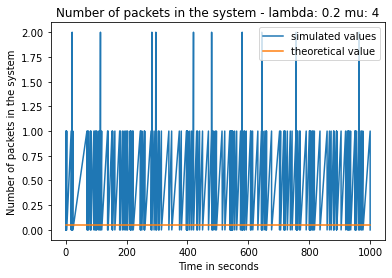

In [12]:
plot_simulation(0.2, 0.1, 1000)
plot_simulation(0.2, 0.3, 1000)
plot_simulation(0.2, 0.5, 1000)
plot_simulation(0.2, 4, 1000)

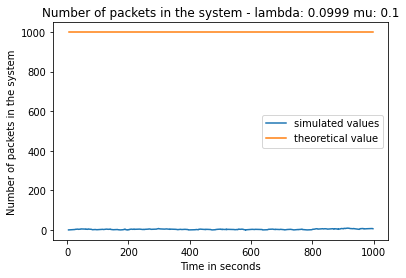

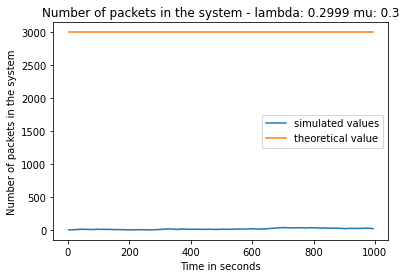

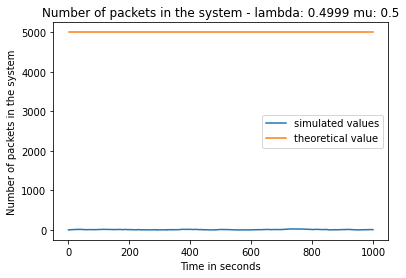

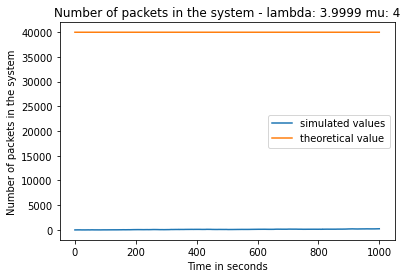

In [13]:
plot_simulation(0.0999, 0.1, 1000)
plot_simulation(0.2999, 0.3, 1000)
plot_simulation(0.4999, 0.5, 1000)
plot_simulation(3.9999, 4, 1000)

In [14]:
def calc_simulation_wait(lmbda, mu, max_time):
    q = simulate(lmbda, max_time)
    s = Server()
    packet_time, packet_status, packet_wait = manage_packets(q, s, mu)

    p = lmbda / mu
    theory_val = p**2 / (lmbda * (1-p))
    theoretical = [theory_val] * len(packet_wait)

    mean_wait = sum(packet_wait) / len(packet_wait)

    print("Lambda: {}, Mu: {}".format(lmbda, mu))
    print("Simulated mean time in queue: {:0.3f}".format(mean_wait))
    print("Theoretical mean time in queue: {:0.3f}".format(theory_val))

    plt.plot(packet_wait)
    plt.plot(theoretical)

    plt.xlabel('Time in seconds')
    plt.ylabel('Queue waiting time')
    plt.legend(['simulated values', 'theoretical value'])
    plt.title('Queue waiting time - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

Lambda: 0.5, Mu: 0.6
Simulated mean time in queue: 11.169
Theoretical mean time in queue: 8.333


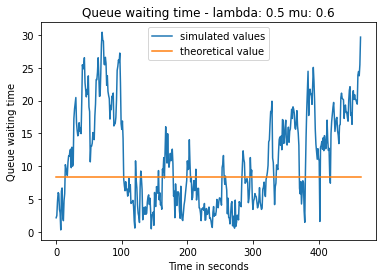

In [15]:
calc_simulation_wait(0.5, 0.6, 1000)

Lambda: 0.1, Mu: 0.099
Simulated mean time in queue: 19.862
Theoretical mean time in queue: -1010.101
Lambda: 0.2, Mu: 0.199
Simulated mean time in queue: 30.391
Theoretical mean time in queue: -1005.025
Lambda: 0.1, Mu: 0.6
Simulated mean time in queue: 3.967
Theoretical mean time in queue: 0.333
Lambda: 0.1, Mu: 1
Simulated mean time in queue: 1.000
Theoretical mean time in queue: 0.111


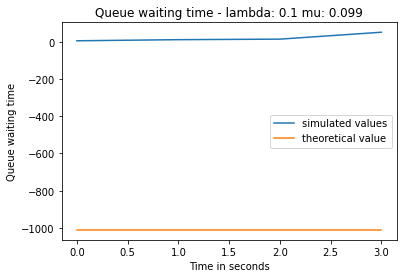

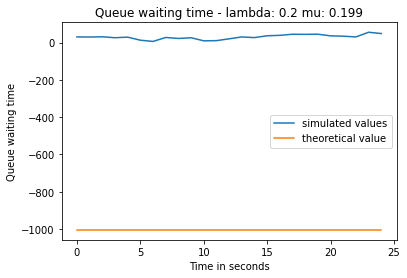

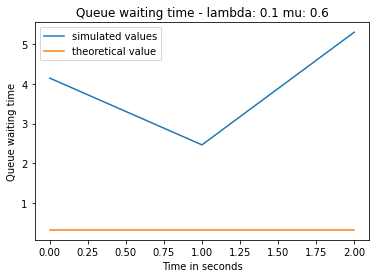

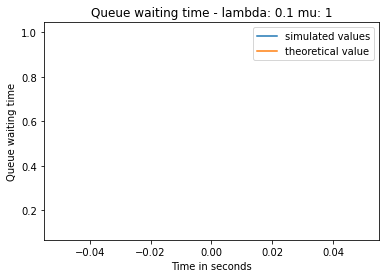

In [16]:
#TODO: find correct parameters

calc_simulation_wait(0.1, 0.099, 200)
calc_simulation_wait(0.2, 0.199, 200)
calc_simulation_wait(0.1, 0.6, 200)
calc_simulation_wait(0.1, 1, 200)

In [17]:
def compute_mean(values):
    return sum(values)/len(values)


def plot_distribution(lmbda, mu, max_time):
    values_ps = []
    values_pw = []
    for i in range(2000):
        q = simulate(lmbda, max_time)
        s = Server()
        packet_time, packet_status, packet_wait = manage_packets(q, s, mu)
        values_ps.append(compute_mean(packet_status))
        values_pw.append(compute_mean(packet_wait))

    plt.hist(values_ps, bins=50)

    plt.title('Packet in the system distribution - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

    plt.hist(values_pw, bins=50)

    plt.title('Queue waiting time distribution - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

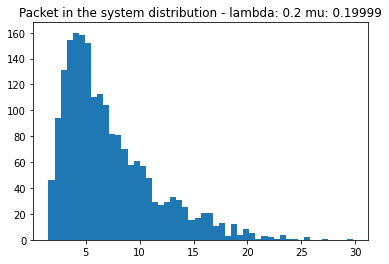

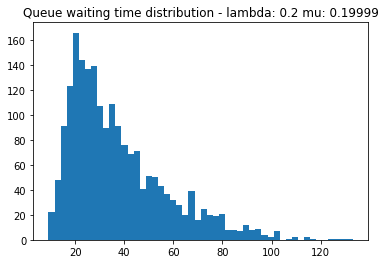

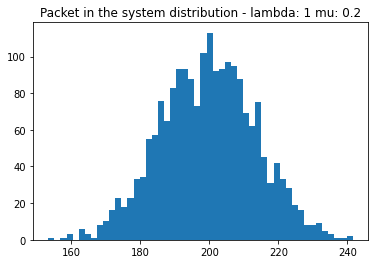

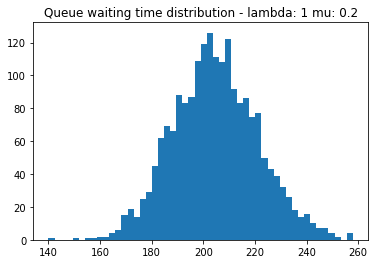

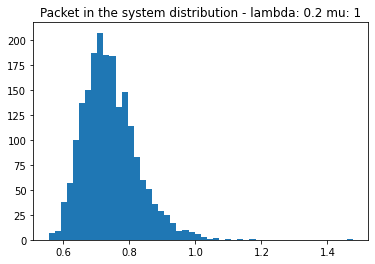

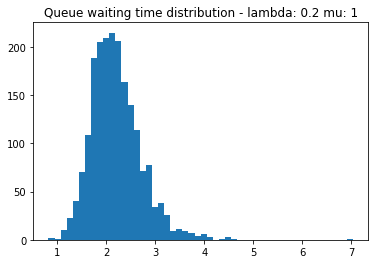

In [43]:
plot_distribution(0.2, 0.19999, 500)
plot_distribution(1, 0.2, 500)
plot_distribution(0.2, 1, 500)

## Exercise 2

In [19]:
class Event:
    def __init__(self, occ_time, event_type:EventTypes):
        self.occurrence_time = occ_time
        self.event_type = event_type
        self.server_idx = None
        self.next_event = None

In [20]:
def manage_packets_MMc(q, servers, server_lambda):
    packet_served = [0] * len(servers)
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            found = False
            for s in range(len(servers)):
                if servers[s].server_status == 0:  # server free
                    servers[s].server_status = 1
                    leave_int = exponential_val(server_lambda)
                    e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                    e.server_idx = s
                    packet_served[s] += 1
                    q.insert_event(e)
                    found = True
                    break
            if not found:  # all servers are busy
                servers[0].queue.append(event)  # use only the queue of the first server for simplicity
        elif event.event_type == EventTypes.packet_departure:
            servers[event.server_idx].server_status = 0
            if len(servers[0].queue):  # schedule next departure event
                for s in range(len(servers)):
                    if servers[s].server_status == 0:  # server free
                        servers[s].server_status = 1
                        leave_int = exponential_val(server_lambda)
                        e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                        e.server_idx = s
                        packet_served[s] += 1
                        q.insert_event(e)

                        servers[0].queue = servers[0].queue[1:]  # remove first packet from the queue
                        break
        elif event.event_type == EventTypes.debug:
            print("debug")
        elif event.event_type == EventTypes.end_simulation:
            break

    return packet_served

In [21]:
def simulate_MMc(lmbda, mu, max_time, c):
    q = simulate(lmbda, max_time)
    s = []
    for i in range(c):
        s.append(Server())
    packet_served = manage_packets_MMc(q, s, mu)

    plt.bar(range(c), packet_served)

    plt.title('Packet served by each server - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

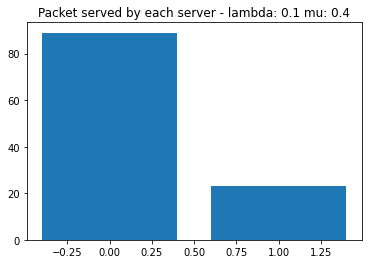

In [22]:
simulate_MMc(0.1, 0.4, 1000, 2)

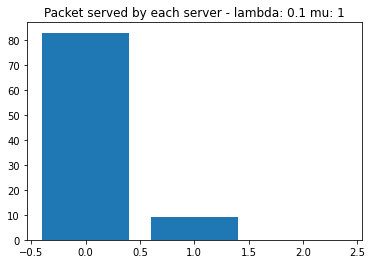

In [23]:
simulate_MMc(0.1, 1, 1000, 3)

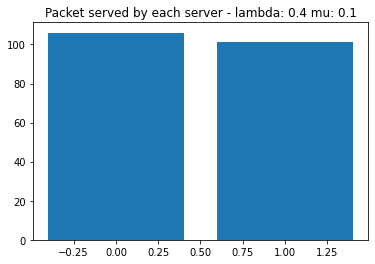

In [24]:
simulate_MMc(0.4, 0.1, 1000, 2)

In [31]:
def get_server_balanced(servers):
    free_srv = []
    for s in range(len(servers)):
        if servers[s].server_status == 0:
            free_srv.append(s)

    if len(free_srv) == 0:
        return None
    srv = rnd.randrange(0, len(free_srv))
    return free_srv[srv]

def manage_packets_MMc_balanced(q, servers, server_lambda):
    packet_served = [0] * len(servers)
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            s = get_server_balanced(servers)

            if s is None:  # all servers are busy
                servers[0].queue.append(event)  # use only the queue of the first server for simplicity
            else:
                servers[s].server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                e.server_idx = s
                packet_served[s] += 1
                q.insert_event(e)
        elif event.event_type == EventTypes.packet_departure:
            servers[event.server_idx].server_status = 0
            if len(servers[0].queue):  # schedule next departure event
                s = get_server_balanced(servers)
                servers[s].server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                e.server_idx = s
                packet_served[s] += 1
                q.insert_event(e)

                servers[0].queue = servers[0].queue[1:]  # remove first packet from the queue
        elif event.event_type == EventTypes.debug:
            print("debug")
        elif event.event_type == EventTypes.end_simulation:
            break

    return packet_served

In [32]:
def simulate_MMc_balanced(lmbda, mu, max_time, c):
    q = simulate(lmbda, max_time)
    s = []
    for i in range(c):
        s.append(Server())
    packet_served = manage_packets_MMc_balanced(q, s, mu)

    plt.bar(range(c), packet_served)

    plt.title('Packet served by each server balanced - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

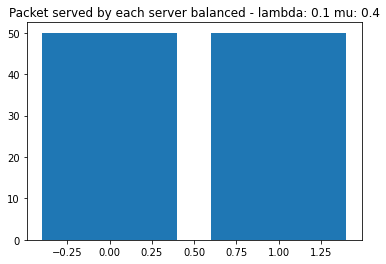

In [33]:
simulate_MMc_balanced(0.1, 0.4, 1000, 2)

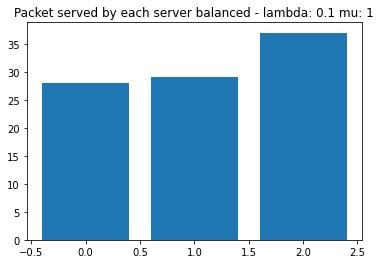

In [34]:
simulate_MMc_balanced(0.1, 1, 1000, 3)

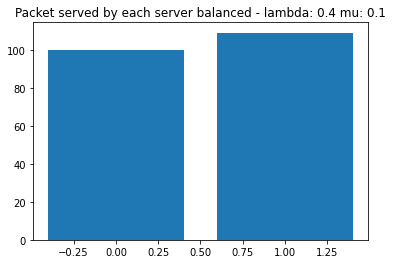

In [35]:
simulate_MMc_balanced(0.4, 0.1, 1000, 2)


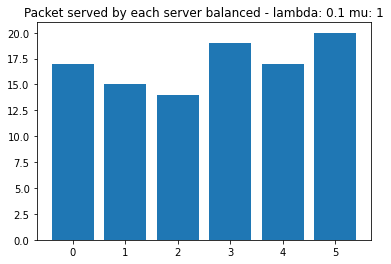

In [41]:

simulate_MMc_balanced(0.1, 1, 1000, 6)
